### STEP 1 : 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA


# Time Series 생성
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2019-08-13    43000.0
2019-08-14    43700.0
2019-08-16    43900.0
2019-08-19    43600.0
2019-08-20    44450.0
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

In [2]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()] 

Series([], Name: Close, dtype: float64)

In [3]:
# 로그 변환 시도 
ts_log = np.log(ts)

### STEP 3 : 시계열 안정성 분석

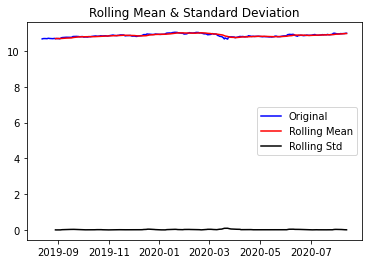

In [4]:
# 정성적 그래프 분석

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(ts_log, window=12)

In [5]:
# 정량적 Augmented Dicky-Fuller Test

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.234029
p-value                          0.194127
#Lags Used                       2.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


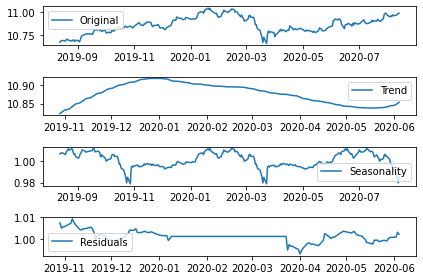

In [6]:
#시계열 분해

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 100)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -3.181817
p-value                          0.021062
#Lags Used                       0.000000
Number of Observations Used    148.000000
Critical Value (1%)             -3.475325
Critical Value (5%)             -2.881275
Critical Value (10%)            -2.577293
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

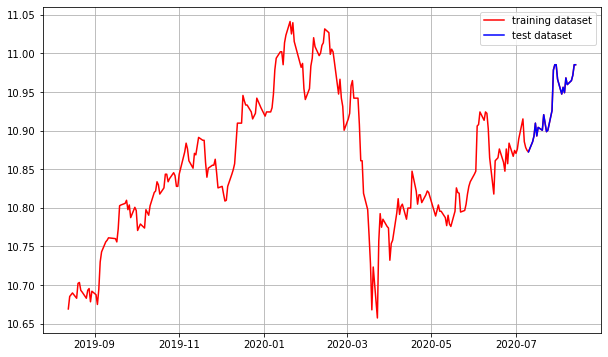

In [8]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)],ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기

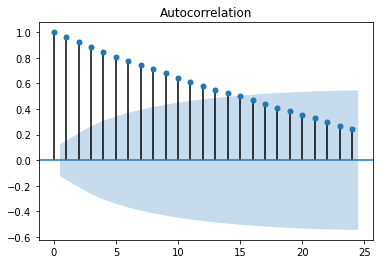

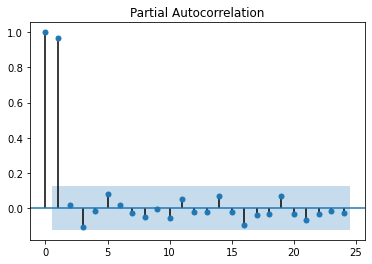

In [9]:
# ACF, PACF 그려보기 -> p,q구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.692671e+00
p-value                        1.125580e-16
#Lags Used                     1.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


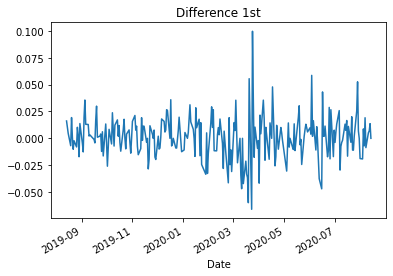

In [10]:
# 차분 안정성 확인 -> d구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.960422e+00
p-value                        2.958828e-12
#Lags Used                     1.400000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


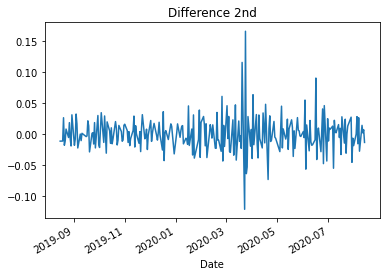

In [11]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6 : ARIMA 모델 훈련과 테스트

In [12]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 554.274
Method:                       css-mle   S.D. of innovations              0.020
Date:                Thu, 13 Aug 2020   AIC                          -1102.547
Time:                        18:02:30   BIC                          -1092.326
Sample:                             1   HQIC                         -1098.421
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      0.704      0.481      -0.002       0.003
ar.L1.D.Close    -0.0343      0.067     -0.513      0.608      -0.165       0.097
                                    Root

/home/aiffel0037/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0037/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


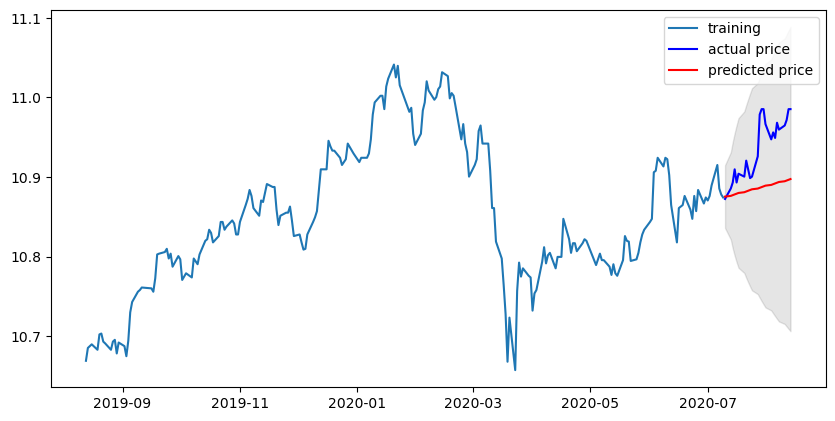

In [13]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  10909837.89614779
MAE:  2804.3982759626856
RMSE:  3303.0043742247435
MAPE: 4.88%


## 다른거 해보기 1. 포스코

### STEP 1 : 시계열 데이터 준비

In [15]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/PKX.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts2 = df['Close']
ts2.head()

Date
2019-08-13    42.950001
2019-08-14    41.349998
2019-08-15    41.549999
2019-08-16    42.380001
2019-08-19    42.970001
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

In [16]:
ts2=ts2.interpolate(method='time')
ts2[ts2.isna()] 


Series([], Name: Close, dtype: float64)

In [17]:
ts2_log=np.log(ts2)

### STEP 3 : 시계열 안정성 분석

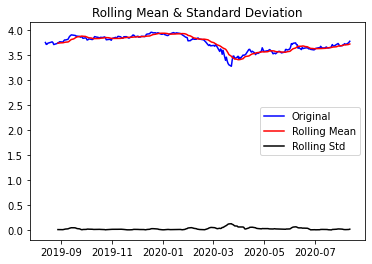

Results of Dickey-Fuller Test:
Test Statistic                  -1.464450
p-value                          0.551018
#Lags Used                       6.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


In [18]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

plot_rolling_statistics(ts2_log, window=12)

augmented_dickey_fuller_test(ts2_log)

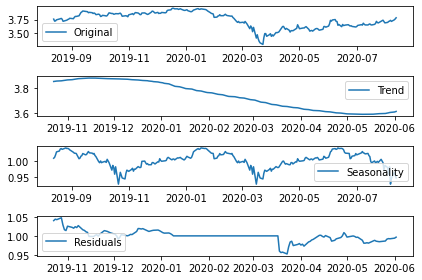

In [19]:
decomposition = seasonal_decompose(ts2_log, model='multiplicative', period = 100)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts2_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [20]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -3.740793
p-value                          0.003575
#Lags Used                       1.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

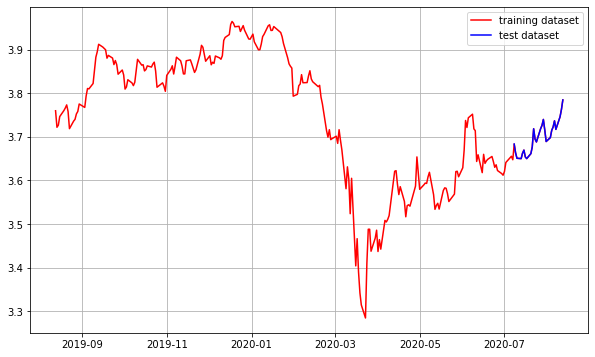

In [21]:
train_data, test_data = ts2_log[:int(len(ts2_log)*0.9)],ts2_log[int(len(ts2_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts2_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기

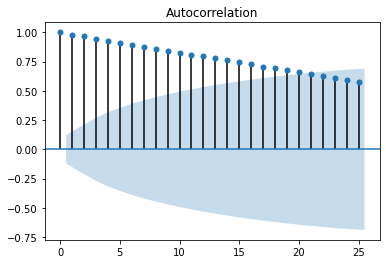

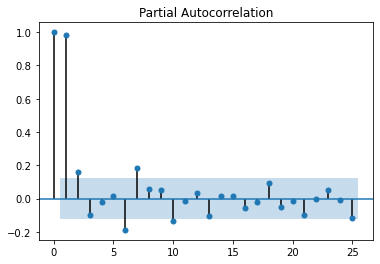

In [22]:
# ACF, PACF 그려보기 -> p,q구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts2_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts2_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -6.548138e+00
p-value                        8.990985e-09
#Lags Used                     5.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


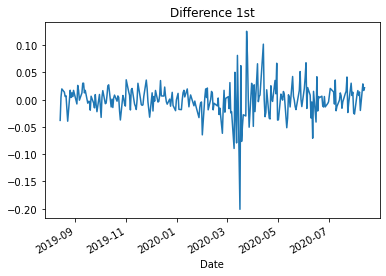

In [23]:
# 차분 안정성 확인 -> d구하기
# 1차 차분 구하기
diff_1 = ts2_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### STEP 6 : ARIMA 모델 훈련과 테스트

In [24]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  #p,d,q pacf를 보면 p는 1로 고정
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 470.478
Method:                       css-mle   S.D. of innovations              0.030
Date:                Thu, 13 Aug 2020   AIC                           -934.956
Time:                        18:02:31   BIC                           -924.695
Sample:                             1   HQIC                          -930.815
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0005      0.002     -0.268      0.789      -0.004       0.003
ar.L1.D.Close    -0.1363      0.066     -2.066      0.039      -0.266      -0.007
                                    Root

/home/aiffel0037/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0037/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


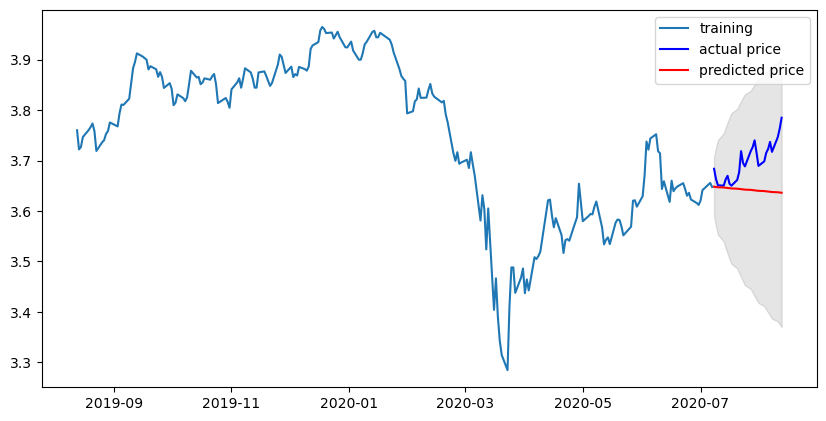

In [25]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7.887685438158367
MAE:  2.30392210528801
RMSE:  2.8085023478997426
MAPE: 5.56%


## 다른거 해보기 2. 나스닥

### STEP 1 : 시계열 데이터 준비

In [27]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import os
# from matplotlib.pylab import rcParams
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.arima_model import ARIMA


# Time Series 생성
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/NQ=F.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts3 = df['Close']
ts3.head()

Date
2019-08-13    7748.00
2019-08-14    7488.75
2019-08-15    7496.25
2019-08-16    7611.75
2019-08-18        NaN
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

In [28]:
# 결측치 처리
ts3=ts3.interpolate(method='time')
ts3[ts3.isna()] 

Series([], Name: Close, dtype: float64)

In [29]:
ts3_log = np.log(ts3)

### STEP 3 : 시계열 안정성 분석

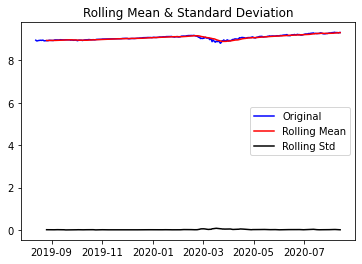

In [30]:
# 정성적 그래프 분석

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(ts3_log, window=12)

In [31]:
# 정량적 Augmented Dicky-Fuller Test

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts3_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.877340
p-value                          0.795343
#Lags Used                       9.000000
Number of Observations Used    296.000000
Critical Value (1%)             -3.452637
Critical Value (5%)             -2.871354
Critical Value (10%)            -2.571999
dtype: float64


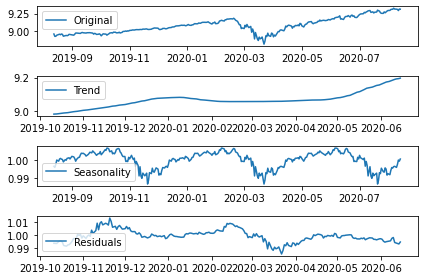

In [32]:
#시계열 분해

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts3_log, model='multiplicative', period = 100)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts3_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [33]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -2.845036
p-value                          0.052123
#Lags Used                       9.000000
Number of Observations Used    196.000000
Critical Value (1%)             -3.464161
Critical Value (5%)             -2.876402
Critical Value (10%)            -2.574692
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

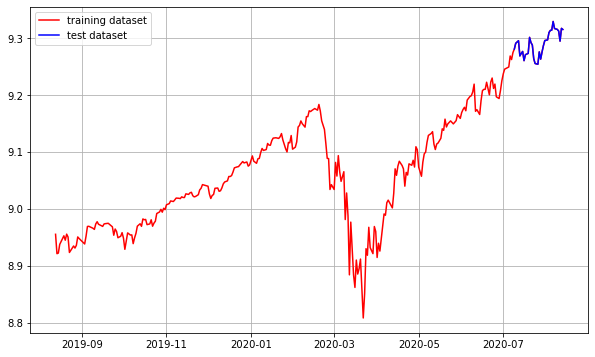

In [34]:
train_data, test_data = ts3_log[:int(len(ts3_log)*0.9)],ts3_log[int(len(ts3_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts3_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기

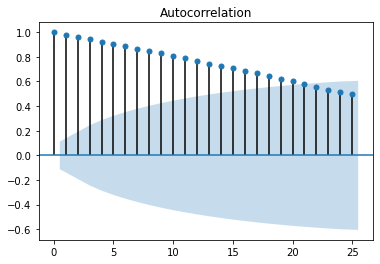

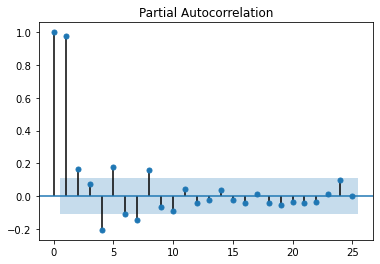

In [35]:
# ACF, PACF 그려보기 -> p,q구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts3_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts3_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -5.160176
p-value                          0.000011
#Lags Used                       8.000000
Number of Observations Used    296.000000
Critical Value (1%)             -3.452637
Critical Value (5%)             -2.871354
Critical Value (10%)            -2.571999
dtype: float64


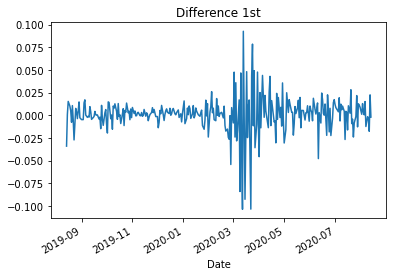

In [36]:
# 차분 안정성 확인 -> d구하기
# 1차 차분 구하기
diff_1 = ts3_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -9.316356e+00
p-value                        1.016675e-15
#Lags Used                     1.000000e+01
Number of Observations Used    2.930000e+02
Critical Value (1%)           -3.452867e+00
Critical Value (5%)           -2.871455e+00
Critical Value (10%)          -2.572053e+00
dtype: float64


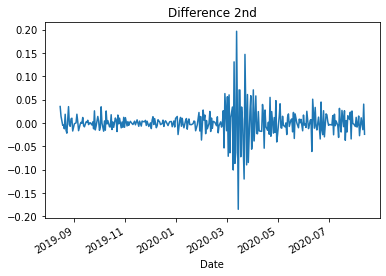

In [37]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6 : ARIMA 모델 훈련과 테스트

In [38]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  #p,d,q pacf를 보면 p는 1로 고정
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  274
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 691.141
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 13 Aug 2020   AIC                          -1376.282
Time:                        18:02:32   BIC                          -1365.443
Sample:                             1   HQIC                         -1371.931
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      1.309      0.191      -0.001       0.003
ar.L1.D.Close    -0.2965      0.058     -5.119      0.000      -0.410      -0.183
                                    Root

/home/aiffel0037/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0037/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


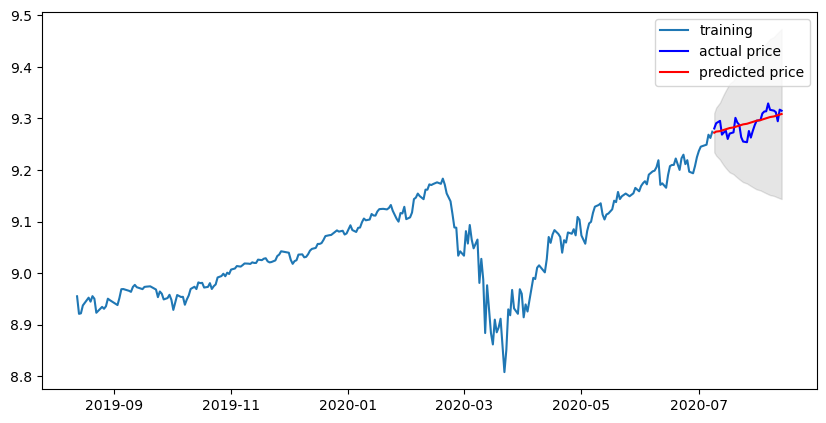

In [39]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  30357.61188185976
MAE:  144.8740912830329
RMSE:  174.23435907380542
MAPE: 1.34%


## 다른거 해보기 3. E-mini Russell 2000 Index Futures

### STEP 1 : 시계열 데이터 준비

In [41]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import os
# from matplotlib.pylab import rcParams
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.arima_model import ARIMA


# Time Series 생성
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/RTY=F.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts4 = df['Close']
ts4.head()

Date
2019-08-13    1513.699951
2019-08-14    1468.300049
2019-08-15    1463.300049
2019-08-16    1493.599976
2019-08-18    1500.699951
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

In [42]:
# 결측치 처리
ts4=ts4.interpolate(method='time')
ts4[ts4.isna()] 

Series([], Name: Close, dtype: float64)

In [43]:
ts4_log = np.log(ts4)

### STEP 3 : 시계열 안정성 분석

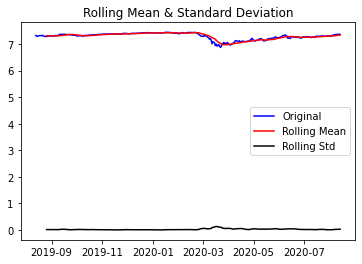

In [44]:
# 정성적 그래프 분석

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(ts4_log, window=12)

In [45]:
# 정량적 Augmented Dicky-Fuller Test

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts4_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.741055
p-value                          0.410093
#Lags Used                       9.000000
Number of Observations Used    296.000000
Critical Value (1%)             -3.452637
Critical Value (5%)             -2.871354
Critical Value (10%)            -2.571999
dtype: float64


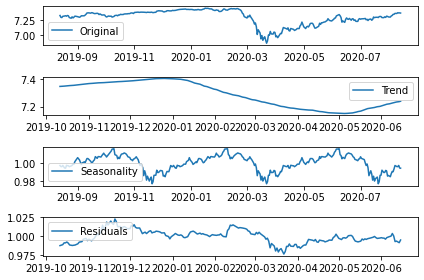

In [46]:
#시계열 분해

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts4_log, model='multiplicative', period = 100)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts4_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [47]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -2.368276
p-value                          0.150891
#Lags Used                       8.000000
Number of Observations Used    197.000000
Critical Value (1%)             -3.463987
Critical Value (5%)             -2.876326
Critical Value (10%)            -2.574652
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

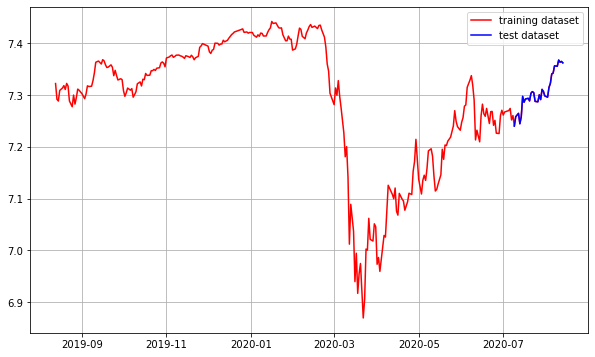

In [48]:
train_data, test_data = ts4_log[:int(len(ts4_log)*0.9)],ts4_log[int(len(ts4_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts4_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기

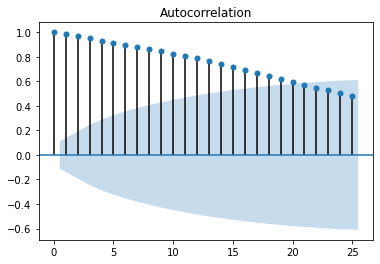

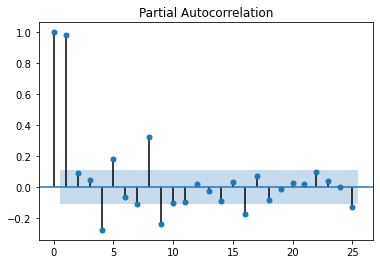

In [49]:
# ACF, PACF 그려보기 -> p,q구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts4_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts4_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -4.966061
p-value                          0.000026
#Lags Used                       8.000000
Number of Observations Used    296.000000
Critical Value (1%)             -3.452637
Critical Value (5%)             -2.871354
Critical Value (10%)            -2.571999
dtype: float64


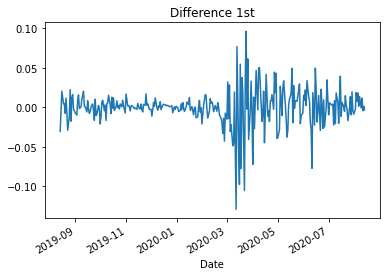

In [50]:
# 차분 안정성 확인 -> d구하기
# 1차 차분 구하기
diff_1 = ts4_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### STEP 6 : ARIMA 모델 훈련과 테스트

In [51]:
# Build Model
model = ARIMA(train_data, order=(1, 0, 0))  #p,d,q pacf를 보면 p는 1로 고정
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  275
Model:                     ARMA(1, 0)   Log Likelihood                 634.883
Method:                       css-mle   S.D. of innovations              0.024
Date:                Thu, 13 Aug 2020   AIC                          -1263.765
Time:                        18:02:33   BIC                          -1252.915
Sample:                             0   HQIC                         -1259.411
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.2891      0.062    118.470      0.000       7.169       7.410
ar.L1.Close     0.9799      0.010     94.230      0.000       0.959       1.000
                                    Roots       

/home/aiffel0037/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


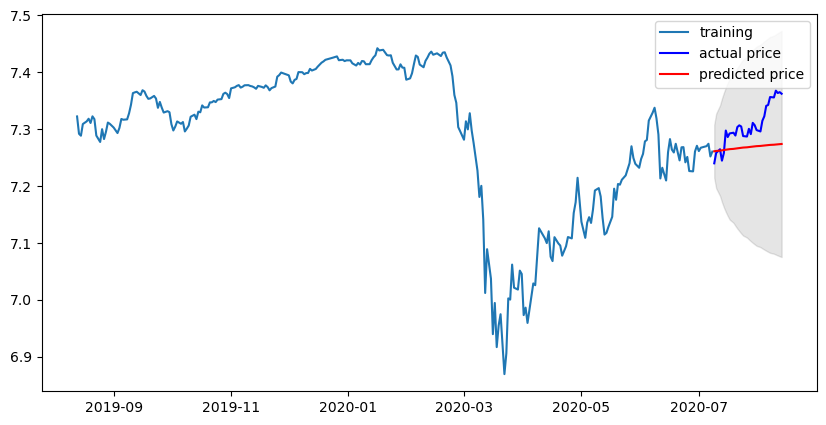

In [52]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5558.156768998983
MAE:  61.72929540467648
RMSE:  74.55304667818065
MAPE: 4.05%


프로젝트를 시작할 때, 뭐부터 해야하지? 단계는 지난 것 같다. 다른 생각 않고 STEP을 처음부터 하나씩 따라가고 있다. 아직 맨 땅에 코드를 써보라고 하면 못할 것 같지만, 그래도 쓰여있는 코드가 어디에 쓰이는지와 무엇을 바꾸면 될지 정도는 알 수 있게 됐다.
p는 시각적으로 확인할 수 있는 예시가 많아서 이번 예시 모두 p를 1로 잡았지만, q는 막연한 상태로 다른 예시가 나왔을 때 구분할 자신이 없다.

총 4개의 예시가 있다보니 꼬이지 않게끔 각자 다른 값으로 잡았다. MAPE는 첫 시도 때부터 10%미만으로 나와서 당황했다. 또 뭘 잘못했나 싶어서 확인했는데 ARIMA 모델 빌드 때 에러가 뜬 걸 뒤늦게 보고 조원에게 물어보고 퍼실님에게 물어보니 그냥 그러려니 하는 눈치였다. 검색해보니까 데이터 사이에 빈 공간이 있을 때 뜨는 버그라고 하는데, 결격 처리 코드는 문제 없어서 넘어갔다. 전체적으로 코드가 다 노드 안에서 마련되어 있어서 변수를 바꿔보는 시간을 다른 때보다 많이 쓸 수 있어서 좋았다.